In [1]:
# Step 1 — Load data & quick EDA
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

def load_data(path="data/raw/outliers_homework.csv"):
    try:
        df = pd.read_csv(path)
        src = "csv"
    except FileNotFoundError:
        df = pd.DataFrame({
            "x": np.random.normal(50, 10, 100).tolist() + [200, 250, 300],
            "y": np.random.normal(100, 20, 100).tolist() + [500, 600, 700],
        })
        src = "synthetic"
    return df, src

df, src = load_data()
print("data_source:", src)
display(df.head())
display(df.info())
display(df.describe().T)
display(df.isna().sum())


data_source: synthetic


,x,y
0,54.967142,71.692585
1,48.617357,91.587094
2,56.476885,93.145710
3,65.230299,83.954455
4,47.658466,96.774286


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       103 non-null    float64
 1   y       103 non-null    float64
dtypes: float64(2)
memory usage: 1.7 KB


None

,count,mean,std,min,25%,50%,75%,max
x,103.0,54.817024,35.821327,23.802549,44.185369,49.279899,55.279137,300.0
y,103.0,114.996206,87.608320,61.624576,84.144694,103.074502,112.822210,700.0


x    0
y    0
dtype: int64

In [2]:
# Step 2 — Reusable functions (IQR / Z-score / Winsorize via quantile+clip)
import pandas as pd
import numpy as np

def detect_outliers_iqr(series: pd.Series) -> pd.Series:
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return (series < lower) | (series > upper)

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    mean = series.mean()
    std = series.std() if series.std() != 0 else 1.0
    z = (series - mean) / std
    return z.abs() > threshold

def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return series.clip(lower=lo, upper=hi)


In [3]:
# Step 3 — Flags and winsorized column
num_cols = df.select_dtypes(include="number").columns.tolist()
assert len(num_cols) >= 1, "Need at least one numeric column"
target_col = num_cols[0]
print("target_col:", target_col)

df["outlier_iqr"] = detect_outliers_iqr(df[target_col])
df["outlier_z"]   = detect_outliers_zscore(df[target_col], threshold=3.0)
df["wins_"+target_col] = winsorize_series(df[target_col], 0.05, 0.95)
df["outlier_any"] = df[["outlier_iqr", "outlier_z"]].any(axis=1)

display(df[[target_col, "outlier_iqr", "outlier_z", "wins_"+target_col]].head(10))
print("outlier_rate_any:", df["outlier_any"].mean())


target_col: x


,x,outlier_iqr,outlier_z,wins_x
0,54.967142,False,False,54.967142
1,48.617357,False,False,48.617357
2,56.476885,False,False,56.476885
3,65.230299,False,False,65.230299
4,47.658466,False,False,47.658466
5,47.658630,False,False,47.658630
6,65.792128,False,False,65.619829
7,57.674347,False,False,57.674347
8,45.305256,False,False,45.305256
9,55.425600,False,False,55.425600


outlier_rate_any: 0.038834951456310676


In [4]:
# Step 4 — Summary comparison
base     = df[target_col]
filtered = df.loc[~df["outlier_iqr"], target_col]
winsed   = df["wins_"+target_col]

summary = pd.DataFrame({
    "n":     [base.size, filtered.size, winsed.size],
    "mean":  [base.mean(), filtered.mean(), winsed.mean()],
    "median":[base.median(), filtered.median(), winsed.median()],
    "std":   [base.std(), filtered.std(), winsed.std()],
}, index=["all", "filtered_iqr", "winsor_5_95"]).round(3)

summary


,n,mean,median,std
all,103,54.817,49.280,35.821
filtered_iqr,99,49.216,48.844,8.763
winsor_5_95,103,49.588,49.280,8.954


In [5]:
# Step 5 — OLS via numpy only
import numpy as np
import pandas as pd

num_cols = df.select_dtypes(include="number").columns.tolist()
assert len(num_cols) >= 2, "Need at least two numeric columns"
x_col, y_col = num_cols[0], num_cols[1]
print("x_col:", x_col, "| y_col:", y_col)

def fit_ols_numpy(x, y):
    X = np.column_stack([np.ones(len(x)), np.asarray(x)])
    beta, *_ = np.linalg.lstsq(X, np.asarray(y), rcond=None)
    yhat = X @ beta
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1 - ss_res/ss_tot if ss_tot != 0 else 0.0
    mae = np.mean(np.abs(y - yhat))
    return {"coef_const": beta[0], "coef_x": beta[1], "R2": r2, "MAE": mae}

res_all = fit_ols_numpy(df[x_col].values, df[y_col].values)
res_fil = fit_ols_numpy(df.loc[~df["outlier_iqr"], x_col].values,
                        df.loc[~df["outlier_iqr"], y_col].values)
res_win = fit_ols_numpy(df["wins_"+x_col].values, df[y_col].values)

pd.DataFrame([res_all, res_fil, res_win], index=["all", "filtered_iqr", "winsor_5_95"]).round(4)


x_col: x | y_col: y


,coef_const,coef_x,R2,MAE
all,-10.7239,2.2935,0.8794,24.2843
filtered_iqr,114.8481,-0.2937,0.0180,15.1183
winsor_5_95,-18.2245,2.6865,0.0754,40.2079


C:\Users\24614\AppData\Local\Temp\ipykernel_23720\3071160414.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df[target_col].dropna(),


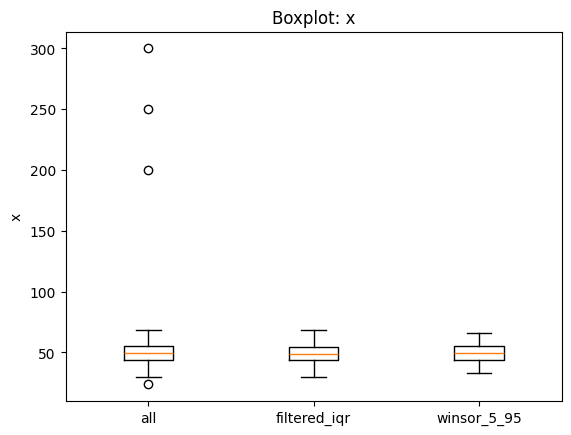

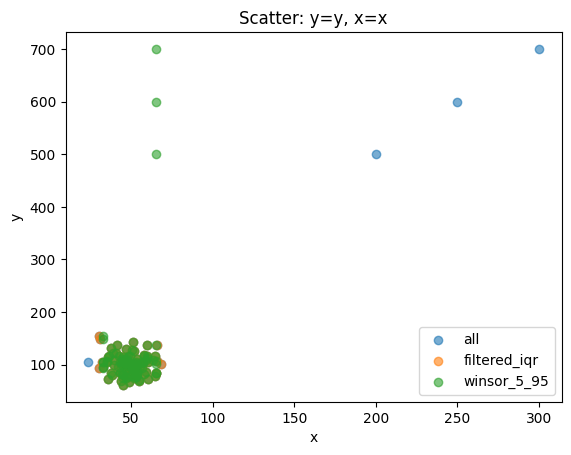

In [6]:
# Step 6 — Plots
plt.figure()
plt.boxplot([df[target_col].dropna(), 
             df.loc[~df["outlier_iqr"], target_col].dropna(), 
             df["wins_"+target_col].dropna()],
            labels=["all", "filtered_iqr", "winsor_5_95"])
plt.title(f"Boxplot: {target_col}")
plt.ylabel(target_col)
plt.show()

plt.figure()
plt.scatter(df[x_col], df[y_col], alpha=0.6, label="all")
plt.scatter(df.loc[~df["outlier_iqr"], x_col], df.loc[~df["outlier_iqr"], y_col], alpha=0.6, label="filtered_iqr")
plt.scatter(df["wins_"+x_col], df[y_col], alpha=0.6, label="winsor_5_95")
plt.legend()
plt.title(f"Scatter: y={y_col}, x={x_col}")
plt.xlabel(x_col); plt.ylabel(y_col)
plt.show()


## Reflection
- Methods and thresholds: IQR (1.5×IQR), Z-score (|Z|>3), Winsorize (5%/95%).
- Why these choices.
- Observed effects on mean/median/std and regression (coef/R²/MAE).
- Assumptions and risks if assumptions fail; mitigation ideas (robust regression, business review).
